100.0%


开始 CNN 模型训练...
Epoch 1/10, Loss: 1.7394, Val Acc: 0.4684
Epoch 2/10, Loss: 1.3741, Val Acc: 0.5296
Epoch 3/10, Loss: 1.2074, Val Acc: 0.5967
Epoch 4/10, Loss: 1.1076, Val Acc: 0.6175
Epoch 5/10, Loss: 1.0126, Val Acc: 0.6512
Epoch 6/10, Loss: 0.9566, Val Acc: 0.6511
Epoch 7/10, Loss: 0.9053, Val Acc: 0.6764
Epoch 8/10, Loss: 0.8647, Val Acc: 0.6999
Epoch 9/10, Loss: 0.8295, Val Acc: 0.7075
Epoch 10/10, Loss: 0.8002, Val Acc: 0.7124
CNN 模型训练结束。
开始特征提取...
特征提取结束。
开始训练随机森林分类器...
Random Forest Test Accuracy: 0.6487


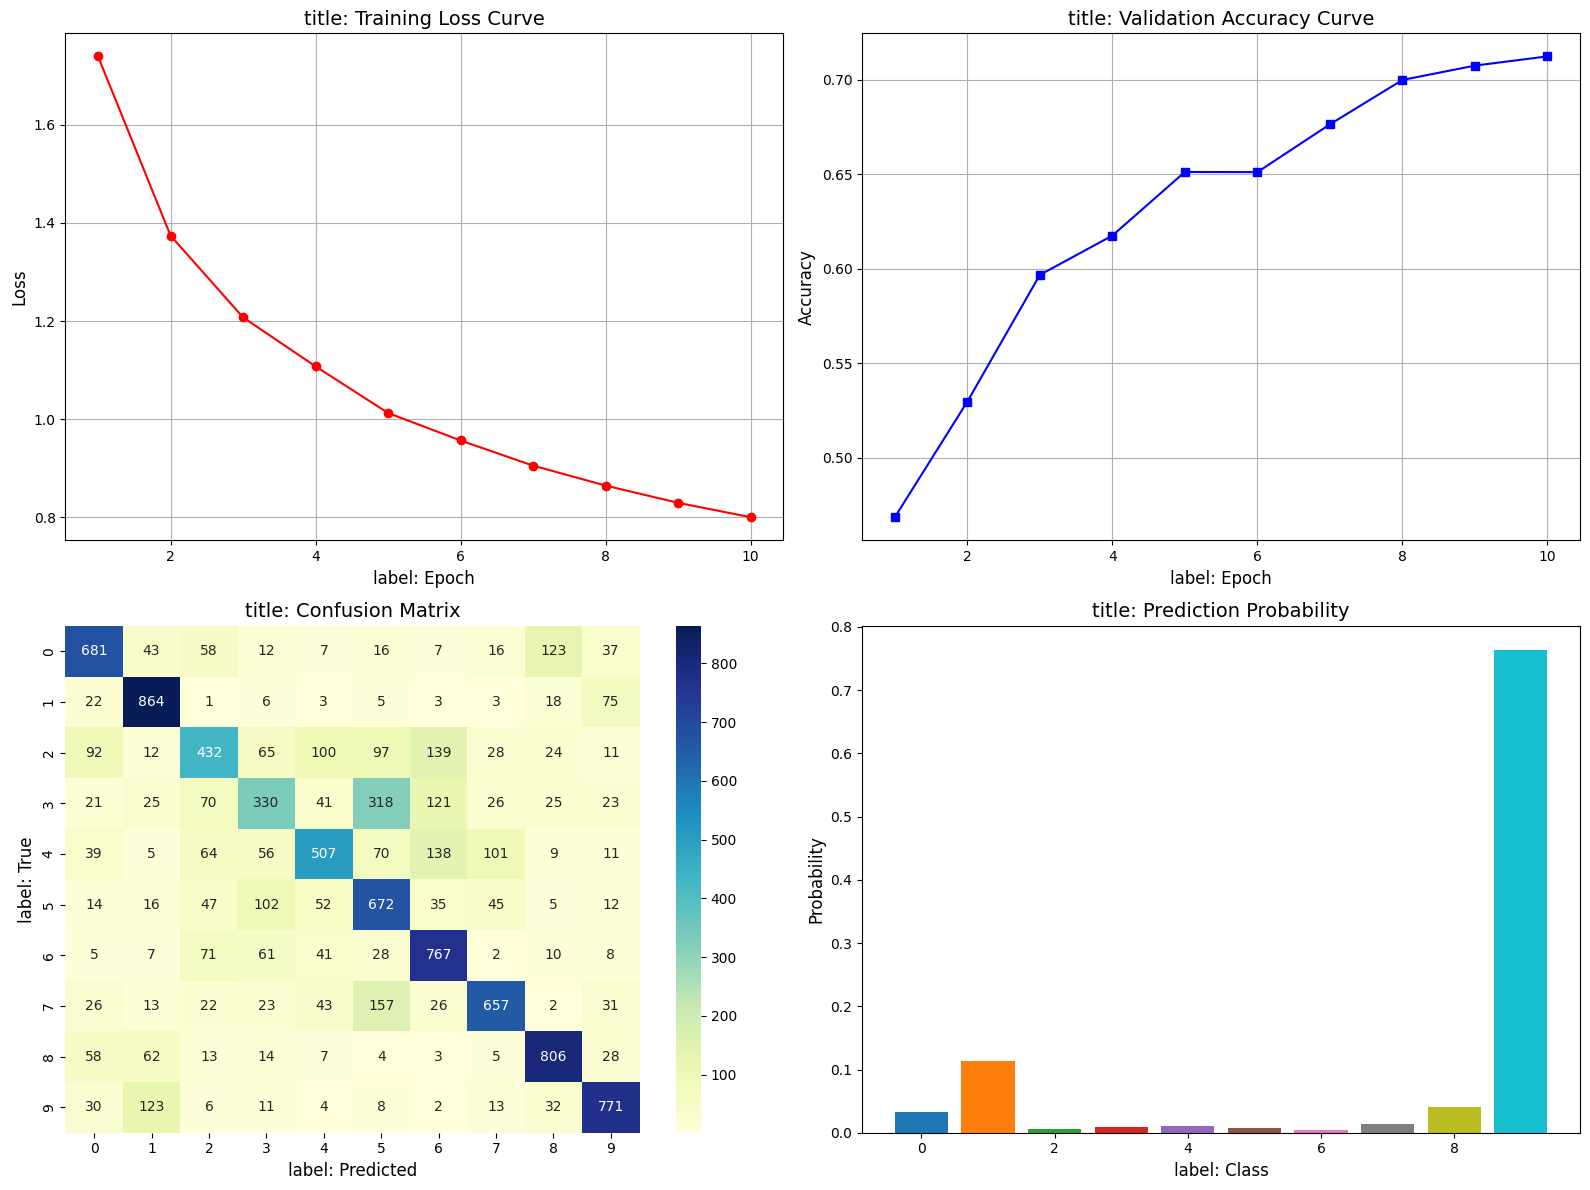

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

# 设置随机种子，保证实验可重复
torch.manual_seed(42)
np.random.seed(42)

# --- 数据预处理 ---
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010))
])

# --- CNN 模型定义 ---
class FeatureExtractorCNN(nn.Module):
    def __init__(self):
        super(FeatureExtractorCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        return x

# --- 主程序 ---
def main():
    # 加载数据
    trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=0)  # 改为 0

    testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)

    device = torch.device("cuda"if torch.cuda.is_available() else"cpu")
    cnn_model = FeatureExtractorCNN().to(device)
    fc_classifier = nn.Linear(256, 10).to(device)
    optimizer_all = optim.Adam(list(cnn_model.parameters()) + list(fc_classifier.parameters()), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_loss_list = []
    val_acc_list = []
    num_epochs = 10

    print("开始 CNN 模型训练...")
    for epoch in range(num_epochs):
        cnn_model.train()
        fc_classifier.train()
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer_all.zero_grad()
            features = cnn_model(images)
            outputs = fc_classifier(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_all.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(trainset)
        train_loss_list.append(epoch_loss)

        cnn_model.eval()
        fc_classifier.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                features = cnn_model(images)
                outputs = fc_classifier(features)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = correct / total
        val_acc_list.append(val_acc)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.4f}")

    print("CNN 模型训练结束。")

    # --- 提取特征 ---
    print("开始特征提取...")
    cnn_model.eval()
    train_features, train_labels = [], []
    with torch.no_grad():
        for images, labels in trainloader:
            images = images.to(device)
            feats = cnn_model(images)
            train_features.append(feats.cpu().numpy())
            train_labels.append(labels.numpy())
    train_features = np.concatenate(train_features, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)

    test_features, test_labels = [], []
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            feats = cnn_model(images)
            test_features.append(feats.cpu().numpy())
            test_labels.append(labels.numpy())
    test_features = np.concatenate(test_features, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    print("特征提取结束。")

    # --- 随机森林训练 ---
    print("开始训练随机森林分类器...")
    rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    rf_classifier.fit(train_features, train_labels)
    rf_pred = rf_classifier.predict(test_features)
    rf_pred_proba = rf_classifier.predict_proba(test_features)
    rf_acc = metrics.accuracy_score(test_labels, rf_pred)
    print(f"Random Forest Test Accuracy: {rf_acc:.4f}")

    # --- 可视化 ---
    plt.figure(figsize=(16, 12))

    plt.subplot(2, 2, 1)
    plt.plot(range(1, num_epochs+1), train_loss_list, marker='o', linestyle='-', color='red')
    plt.title("title: Training Loss Curve", fontsize=14)
    plt.xlabel("label: Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(range(1, num_epochs+1), val_acc_list, marker='s', linestyle='-', color='blue')
    plt.title("title: Validation Accuracy Curve", fontsize=14)
    plt.xlabel("label: Epoch", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.grid(True)

    plt.subplot(2, 2, 3)
    cm = metrics.confusion_matrix(test_labels, rf_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")
    plt.title("title: Confusion Matrix", fontsize=14)
    plt.xlabel("label: Predicted", fontsize=12)
    plt.ylabel("label: True", fontsize=12)

    plt.subplot(2, 2, 4)
    sample_index = np.random.randint(0, len(test_features))
    sample_proba = rf_pred_proba[sample_index]
    plt.bar(range(10), sample_proba, color=plt.cm.tab10.colors)
    plt.title("title: Prediction Probability", fontsize=14)
    plt.xlabel("label: Class", fontsize=12)
    plt.ylabel("Probability", fontsize=12)

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    main()
